In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


Matplotlib is building the font cache; this may take a moment.


Loading data...
Data loaded with shape: (624, 1000)
Features shape: (624, 999)
Step 1: Computing similarity matrix...
Step 2: Identifying initial neighbors and densities...
Step 3: Preparing for cluster merging...
Step 4: Merging overlapping clusters...
Step 5: Refining clusters and handling outliers...

Clustering Results:
  Initial clusters: 607
  Final clusters: 35
  Total samples: 624
  Samples in clusters: 576
  Outliers: 48 (7.69%)

Cluster size distribution:
  Min size: 6
  Max size: 85
  Average size: 32.71
  Largest clusters: [85, 64, 62, 59, 55]


/var/folders/px/5k5grmpn7m1683gh7vt2xhsw0000gn/T/ipykernel_30128/4045263844.py:229: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


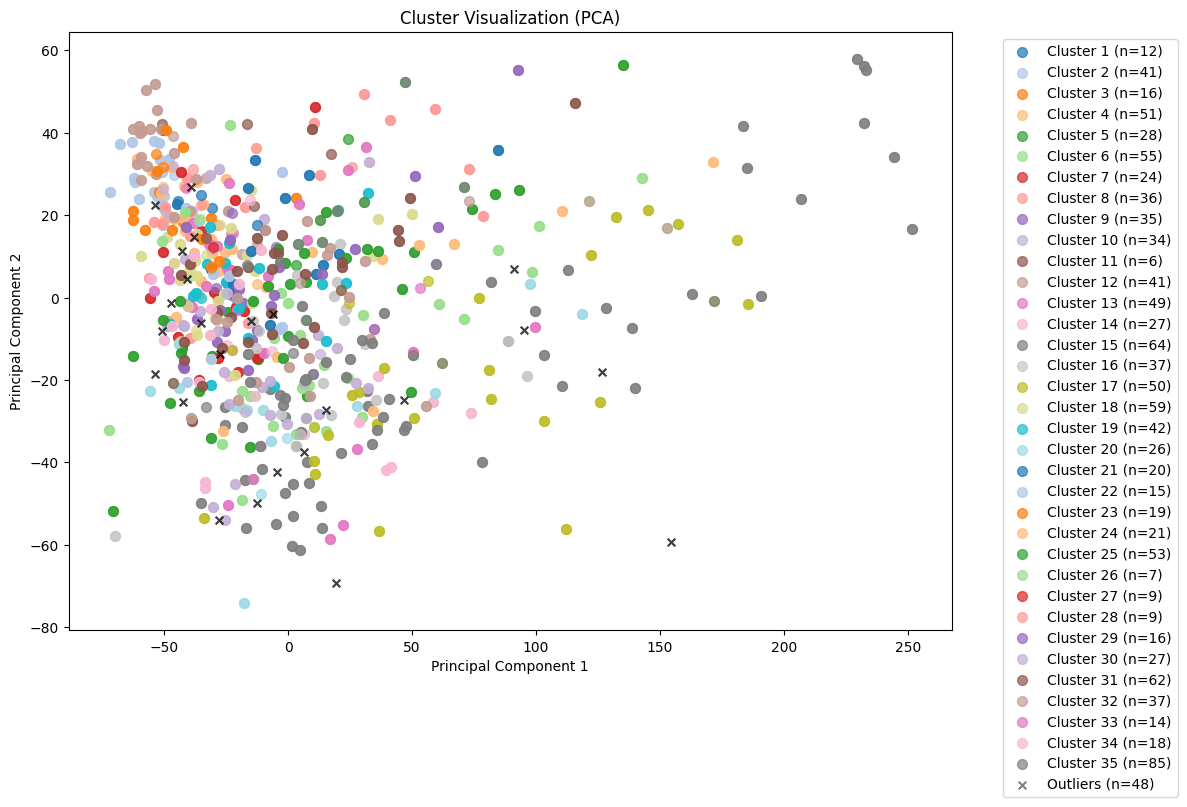

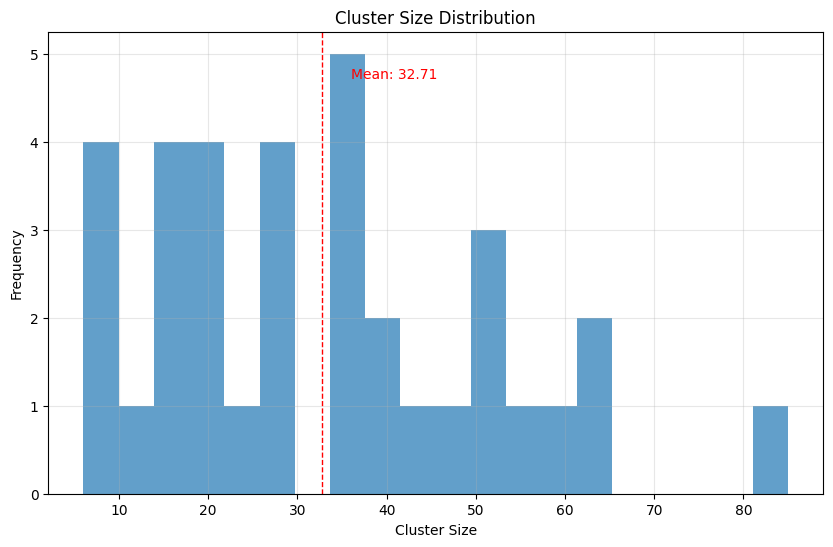


Evaluating clusters with provided labels:
Cluster 1: Label = 8.44, Purity = 0.17
Cluster 2: Label = 8.58, Purity = 0.05
Cluster 3: Label = 9.81, Purity = 0.12
Cluster 4: Label = 13.0, Purity = 0.04
Cluster 5: Label = 10.4, Purity = 0.07
Cluster 6: Label = 16.8, Purity = 0.04
Cluster 7: Label = 37.7, Purity = 0.08
Cluster 8: Label = 9.99, Purity = 0.06
Cluster 9: Label = 21.0, Purity = 0.09
Cluster 10: Label = 30.5, Purity = 0.06
Cluster 11: Label = 9.57, Purity = 0.33
Cluster 12: Label = 7.67, Purity = 0.10
Cluster 13: Label = 7.16, Purity = 0.08
Cluster 14: Label = 14.7, Purity = 0.07
Cluster 15: Label = 24.2, Purity = 0.06
Cluster 16: Label = 17.4, Purity = 0.11
Cluster 17: Label = 24.1, Purity = 0.04
Cluster 18: Label = 10.1, Purity = 0.07
Cluster 19: Label = 12.7, Purity = 0.05
Cluster 20: Label = 18.7, Purity = 0.08
Cluster 21: Label = 10.3, Purity = 0.20
Cluster 22: Label = 17.1, Purity = 0.13
Cluster 23: Label = 7.56, Purity = 0.16
Cluster 24: Label = 18.1, Purity = 0.10
Cluste

In [ ]:


# Function to normalize the data and compute similarity matrix
def normalized_euclidean_similarity(X):
    """ Compute (1 - normalized Euclidean distance) similarity matrix """
    # Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Euclidean distances
    distances = cdist(X_scaled, X_scaled, metric='euclidean')
    
    # Normalize distances to [0, 1]
    max_dist = distances.max()
    normalized_dist = distances / max_dist
    
    # Convert to similarity
    similarity = 1 - normalized_dist
    return similarity

# Function to identify neighbors based on similarity threshold
def build_clusters(similarity_matrix, r=0.9):
    """ Identify neighbors based on similarity threshold and count densities """
    n_samples = similarity_matrix.shape[0]
    clusters = []
    densities = []
    
    for i in range(n_samples):
        neighbors = np.where(similarity_matrix[i] >= r)[0]
        clusters.append(neighbors)
        densities.append(len(neighbors))
    
    return clusters, densities

# Function to merge overlapping clusters
def merge_clusters(sample_info_sorted, threshold=0.5):
    """
    Merge clusters if they share more than `threshold` of the total number of samples.
    The merging will be based on the ratio of common samples to the total distinct samples.
    """
    merged = []
    visited = set()

    for i, density_i, cluster_i in sample_info_sorted:
        if i in visited:
            continue

        # Start new merged cluster
        merged_cluster = set(cluster_i)
        merged_indices = {i}
        visited.add(i)

        changed = True
        while changed:
            changed = False
            for j, density_j, cluster_j in sample_info_sorted:
                if j in visited:
                    continue

                set_j = set(cluster_j)
                common = merged_cluster.intersection(set_j)  # common samples
                union = merged_cluster.union(set_j)  # total distinct samples
                common_size = len(common)
                union_size = len(union)

                # Calculate the ratio of common samples to total distinct samples
                similarity_ratio = common_size / union_size if union_size > 0 else 0

                # Merge if similarity ratio exceeds threshold
                if similarity_ratio > threshold:
                    merged_cluster.update(set_j)
                    visited.add(j)
                    merged_indices.add(j)
                    changed = True

        merged.append(list(merged_cluster))

    return merged

# Function to remove outliers and assign samples to exactly one cluster
def remove_outliers_and_assign_unique_clusters(merged_clusters, similarity_matrix, outlier_threshold=0.75):
    """
    Refine clusters by:
    1. Removing duplicates (assigning each sample to exactly one cluster)
    2. Identifying and handling outliers
    3. Reassigning samples to their most appropriate cluster
    
    Parameters:
    - merged_clusters: List of clusters, where each cluster is a list of sample indices
    - similarity_matrix: Matrix of similarity scores between samples
    - outlier_threshold: Minimum average similarity a sample must have to its cluster
    
    Returns:
    - refined_clusters: List of refined clusters with unique sample assignments
    - cluster_assignments: Dictionary mapping sample index to assigned cluster index
    - outliers: List of outlier sample indices
    """
    n_samples = similarity_matrix.shape[0]
    
    # Initialize tracking variables
    cluster_assignments = {}  # Maps sample index to assigned cluster index
    assigned_samples = set()  # Tracks which samples have been assigned
    outliers = []  # List to store outlier samples
    refined_clusters = [[] for _ in range(len(merged_clusters))]
    
    # Sort clusters by size (descending) for stability - prioritize larger clusters
    sorted_clusters = sorted([(idx, cluster) for idx, cluster in enumerate(merged_clusters)], 
                            key=lambda x: len(x[1]), reverse=True)
    
    # First pass: Assign each sample to its most similar cluster when in multiple clusters
    for sample_idx in range(n_samples):
        # Find all clusters containing this sample
        containing_clusters = []
        for cluster_idx, (orig_idx, cluster) in enumerate(sorted_clusters):
            if sample_idx in cluster:
                containing_clusters.append((orig_idx, cluster))
        
        if not containing_clusters:
            # Sample isn't in any cluster yet - will handle in second pass
            continue
        
        # Calculate average similarity to each containing cluster
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for orig_idx, cluster in containing_clusters:
            # Calculate average similarity to other samples in this cluster
            similarities = []
            for other_sample in cluster:
                if other_sample != sample_idx:  # Exclude self-similarity
                    similarities.append(similarity_matrix[sample_idx, other_sample])
            
            if similarities:  # Ensure cluster has other samples
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = orig_idx
        
        # Check if the sample is an outlier based on similarity threshold
        if best_avg_similarity < outlier_threshold:
            outliers.append(sample_idx)
        else:
            # Assign sample to its best-fitting cluster
            cluster_assignments[sample_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(sample_idx)
            assigned_samples.add(sample_idx)
    
    # Second pass: Handle unassigned samples (not in any initial cluster)
    unassigned = set(range(n_samples)) - assigned_samples
    
    for sample_idx in unassigned:
        # Find the cluster with highest average similarity
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(refined_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Calculate average similarity to this cluster
            similarities = [similarity_matrix[sample_idx, other_sample] for other_sample in cluster]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # Check if sample should be an outlier
        if best_avg_similarity < outlier_threshold:
            outliers.append(sample_idx)
        else:
            # Assign to best cluster
            cluster_assignments[sample_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(sample_idx)
            assigned_samples.add(sample_idx)
    
    # Final pass: Try to reassign outliers to the most similar cluster with relaxed threshold
    for outlier_idx in outliers.copy():  # Use copy to allow modification during iteration
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(refined_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Calculate average similarity to this cluster
            similarities = [similarity_matrix[outlier_idx, other_sample] for other_sample in cluster]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # Use a more lenient threshold for outlier reassignment
        relaxed_threshold = outlier_threshold * 0.8
        if best_avg_similarity >= relaxed_threshold:
            cluster_assignments[outlier_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(outlier_idx)
            outliers.remove(outlier_idx)
    
    # Remove empty clusters
    final_clusters = []
    final_assignments = {}
    
    for new_idx, cluster in enumerate([c for c in refined_clusters if c]):
        final_clusters.append(cluster)
        for sample in cluster:
            final_assignments[sample] = new_idx
    
    return final_clusters, final_assignments, outliers

# Function to visualize clustering results
def visualize_clustering_results(data, final_clusters, outliers, cluster_assignments):
    """
    Visualize the clustering results using dimensionality reduction
    """
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    # Create a colormap for the clusters
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(final_clusters))]
    
    # Plot clusters and outliers
    plt.figure(figsize=(12, 8))
    
    # Plot each cluster
    for idx, cluster in enumerate(final_clusters):
        if len(cluster) > 0:
            cluster_points = data_2d[cluster]
            plt.scatter(
                cluster_points[:, 0], 
                cluster_points[:, 1], 
                color=colors[idx], 
                alpha=0.7, 
                s=50, 
                label=f'Cluster {idx+1} (n={len(cluster)})'
            )
    
    # Plot outliers
    if outliers:
        outlier_points = data_2d[outliers]
        plt.scatter(
            outlier_points[:, 0], 
            outlier_points[:, 1], 
            color='black', 
            marker='x', 
            alpha=0.5, 
            s=30, 
            label=f'Outliers (n={len(outliers)})'
        )
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
    plt.tight_layout()
    plt.show()
    
    # Plot cluster size distribution
    cluster_sizes = [len(cluster) for cluster in final_clusters]
    plt.figure(figsize=(10, 6))
    plt.hist(cluster_sizes, bins=20, alpha=0.7)
    plt.axvline(np.mean(cluster_sizes), color='r', linestyle='dashed', linewidth=1)
    plt.text(
        np.mean(cluster_sizes)*1.1, 
        plt.ylim()[1]*0.9, 
        f'Mean: {np.mean(cluster_sizes):.2f}', 
        color='r'
    )
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

# Main function to run the improved clustering pipeline
def improved_clustering_pipeline(data, initial_r=0.862, merge_threshold=0.5, outlier_threshold=0.75):
    """
    Enhanced clustering pipeline that ensures each sample belongs to exactly one cluster
    and handles outliers appropriately.
    """
    print("Step 1: Computing similarity matrix...")
    similarity = normalized_euclidean_similarity(data)
    
    print("Step 2: Identifying initial neighbors and densities...")
    clusters, densities = build_clusters(similarity, r=initial_r)
    
    print("Step 3: Preparing for cluster merging...")
    sample_info = [(i, densities[i], clusters[i]) for i in range(len(clusters))]
    sample_info_sorted = sorted(sample_info, key=lambda x: x[1], reverse=True)
    
    print("Step 4: Merging overlapping clusters...")
    merged_clusters = merge_clusters(sample_info_sorted, threshold=merge_threshold)
    
    print("Step 5: Refining clusters and handling outliers...")
    final_clusters, cluster_assignments, outliers = remove_outliers_and_assign_unique_clusters(
        merged_clusters, similarity, outlier_threshold=outlier_threshold
    )
    
    # Print summary statistics
    print(f"\nClustering Results:")
    print(f"  Initial clusters: {len(merged_clusters)}")
    print(f"  Final clusters: {len(final_clusters)}")
    print(f"  Total samples: {data.shape[0]}")
    print(f"  Samples in clusters: {data.shape[0] - len(outliers)}")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/data.shape[0]*100:.2f}%)")
    
    # Show cluster size distribution
    cluster_sizes = [len(cluster) for cluster in final_clusters]
    print(f"\nCluster size distribution:")
    print(f"  Min size: {min(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Max size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Average size: {sum(cluster_sizes)/len(cluster_sizes) if cluster_sizes else 0:.2f}")
    print(f"  Largest clusters: {sorted(cluster_sizes, reverse=True)[:5]}")
    
    return final_clusters, cluster_assignments, outliers, similarity

# Function to evaluate clustering results
def evaluate_clusters(final_clusters, outliers, labels):
    """
    Evaluate the quality of clusters using known labels (if available)
    """
    # Create a mapping of cluster_idx to most common label in that cluster
    from collections import Counter
    
    cluster_labels = {}
    for cluster_idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_label_counts = Counter([labels[sample_idx] for sample_idx in cluster])
            most_common_label = cluster_label_counts.most_common(1)[0][0]
            cluster_labels[cluster_idx] = most_common_label
            
            # Calculate purity (% of samples with most common label)
            purity = cluster_label_counts[most_common_label] / len(cluster)
            print(f"Cluster {cluster_idx+1}: Label = {most_common_label}, Purity = {purity:.2f}")
    
    # Calculate overall purity
    correct_assignments = 0
    total_in_clusters = 0
    
    for cluster_idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_label = cluster_labels[cluster_idx]
            correct_in_cluster = sum(1 for sample_idx in cluster if labels[sample_idx] == cluster_label)
            correct_assignments += correct_in_cluster
            total_in_clusters += len(cluster)
    
    overall_purity = correct_assignments / total_in_clusters if total_in_clusters > 0 else 0
    print(f"\nOverall cluster purity: {overall_purity:.2f}")
    
    # Check outliers
    if outliers:
        outlier_label_counts = Counter([labels[sample_idx] for sample_idx in outliers])
        print("\nOutlier distribution:")
        for label, count in outlier_label_counts.most_common():
            print(f"  Label {label}: {count} samples ({count/len(outliers)*100:.2f}%)")

# Main execution function
def run_clustering_analysis():
    # Load your data - using your CSV file path 
    print("Loading data...")
    data = pd.read_csv("../data/vpufs_reduced_features.csv")
    
    # Data preprocessing as in your original code
    data = data.dropna(axis=1)
    data = data.loc[:, ~data.columns.duplicated()]
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.dropna()
    
    # Extract labels and features
    labels = data.iloc[:, -1].values
    features_df = data.drop(data.columns[-1], axis=1)
    
    print(f"Data loaded with shape: {data.shape}")
    print(f"Features shape: {features_df.shape}")
    
    # Run the clustering pipeline
    final_clusters, cluster_assignments, outliers, similarity = improved_clustering_pipeline(
        features_df,
        initial_r=0.862,        # Initial similarity threshold
        merge_threshold=0.5,    # Threshold for merging clusters  
        outlier_threshold=0.75  # Threshold for identifying outliers
    )
    
    # Visualize the results (if matplotlib is available)
    try:
        visualize_clustering_results(features_df.values, final_clusters, outliers, cluster_assignments)
    except ImportError:
        print("Visualization libraries not available. Skipping visualization.")
    
    # Evaluate clustering (if labels are available)
    if labels is not None and len(labels) > 0:
        print("\nEvaluating clusters with provided labels:")
        evaluate_clusters(final_clusters, outliers, labels)
    
    # Save results to CSV
    save_results_to_csv(data, final_clusters, outliers, cluster_assignments)
    
    return final_clusters, cluster_assignments, outliers, similarity

def save_results_to_csv(data, final_clusters, outliers, cluster_assignments):
    """Save clustering results to CSV files"""
    # Create DataFrame with original data and cluster assignments
    result_df = data.copy()
    
    # Add cluster assignment column
    cluster_column = [-1] * len(data)  # Initialize all to -1 (outlier)
    for sample_idx, cluster_idx in cluster_assignments.items():
        cluster_column[sample_idx] = cluster_idx
    
    result_df['cluster'] = cluster_column
    
    # Save to CSV
    result_df.to_csv("clustering_results.csv", index=False)
    print("Results saved to 'clustering_results.csv'")
    
    # Save cluster summary
    cluster_summary = []
    for cluster_idx, cluster in enumerate(final_clusters):
        cluster_summary.append({
            'cluster_id': cluster_idx,
            'size': len(cluster),
            'samples': str(sorted(cluster))
        })
    
    summary_df = pd.DataFrame(cluster_summary)
    summary_df.to_csv("cluster_summary.csv", index=False)
    print("Cluster summary saved to 'cluster_summary.csv'")


# Run the analysis if the script is executed directly
if __name__ == "__main__":
    final_clusters, cluster_assignments, outliers, similarity = run_clustering_analysis()
    